In [1]:
import sys
!{sys.executable} -m pip install xgboost

In [2]:
# pip install researchpy

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import yaml
import seaborn as sns
sns.set()

from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost.sklearn import XGBRegressor
import pickle
from sklearn.externals import joblib 
import itertools as it

C:\Users\anuka\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Adds style to the printed dataframe output
from IPython.core.display import HTML
css = open('C:/Users/anuka/OneDrive/Desktop/Anu/Interview Prep/Springboard/Curriculum/Unit 5/Pandas from the ground up/pycon-pandas-tutorial-master/pycon-pandas-tutorial-master/style-table.css').read() + open('C:/Users/anuka/OneDrive/Desktop/Anu/Interview Prep/Springboard/Curriculum/Unit 5/Pandas from the ground up/pycon-pandas-tutorial-master/pycon-pandas-tutorial-master/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [5]:
# def clean_data(df, remove_lead_trail_spaces, remove_invalid_values):
    
#     for col in remove_lead_trail_spaces:
#         df[col] =  df[col].str.strip()
# #         df[col] = df[col].replace(['nan','',' ','.'], np.nan)
#     for col in remove_invalid_values:
#         df[df[col]>150][col] = np.nan

#     return df

In [6]:
# def generate_columns_yaml(df):
#         cols_list = df.columns.tolist()
#         cols_dict = {}
#         for col in cols_list:
#             five_values = str(df[col].sample(5).tolist())
#             dtype = str(df[col].dtype)
#             try:
#                 fill_rate = str(int(df[col].isnull().value_counts(normalize=True)[False]*100)) + ' %' 
#             except:
#                 fill_rate = '0 %'
#             cols_dict[col] = {'5_sample_values':five_values, 'fill_rate': fill_rate,'orig_dtype':dtype,'recast_dtype':dtype, 'tag':'n'}
#         yaml.dump(cols_dict, open("C:/Users/anuka/OneDrive/Desktop/Anu/Interview Prep/Springboard/Curriculum/Capstone project 1/Code/columns.yaml", "w"), default_flow_style=False)
#         pd.DataFrame(cols_dict).transpose().to_excel('C:/Users/anuka/OneDrive/Desktop/Anu/Interview Prep/Springboard/Curriculum/Capstone project 1/Code/fill_rate.xlsx')
#         pass

## Load all datasets

In [7]:
os.chdir("C:/Users/anuka/OneDrive/Desktop/Anu/Interview Prep/Springboard/Curriculum/Capstone project 1/airbnb-recruiting-new-user-bookings")

# Load and clean training dataset
df_train = pd.read_csv("train_users_2.csv",parse_dates=True, skiprows=0, na_values = ['NaN'], encoding='utf-8')
df_train['timestamp_first_active'] = pd.to_datetime(df_train['timestamp_first_active'])
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_train['date_first_booking'] = pd.to_datetime(df_train['date_first_booking'])

# Load and clean test dataset
df_test = pd.read_csv("test_users.csv",parse_dates=True, skiprows=0, na_values = ['NaN'])
df_test['timestamp_first_active'] = pd.to_datetime(df_test['timestamp_first_active'])
df_test['date_account_created'] = pd.to_datetime(df_test['date_account_created'])
df_test['date_first_booking'] = pd.to_datetime(df_test['date_first_booking'])
# df_test.head()

# Load and clean sessions dataset
df_sessions = pd.read_csv("sessions.csv",parse_dates=True, skiprows=0, na_values = ['NaN'])

# Load and clean countries dataset
df_countries = pd.read_csv("countries.csv",parse_dates=True, skiprows=0, na_values = ['NaN'])

# Load and clean age_gender_bkts dataset
# This dataset contains number of male/female in different age buckets who travelled to these destination countries in 2015 
df_age_gender_bkts = pd.read_csv("age_gender_bkts.csv",parse_dates=True, skiprows=0, na_values = ['NaN'])


# Look at shape of each dataset loaded

In [8]:
print("The shape of training dataset is: ", df_train.shape)
print("The shape of test dataset is: ", df_test.shape)
print("The shape of sessions dataset is: ", df_sessions.shape)
print("The shape of countries dataset is: ", df_countries.shape)
print("The shape of age_gender_buckets dataset is: ", df_age_gender_bkts.shape)
df_train.head(2)

The shape of training dataset is:  (213451, 16)
The shape of test dataset is:  (62096, 15)
The shape of sessions dataset is:  (10567737, 6)
The shape of countries dataset is:  (10, 7)
The shape of age_gender_buckets dataset is:  (420, 5)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,1970-01-01 05:34:50.319043255,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,1970-01-01 05:34:50.523174809,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


In [9]:
# Get the language of the destination country and see if it's the same as "international language preference"
# Clean the columns of 'countries' dataset
df_countries.columns = ['country_destination', 'lat_destination', 'lng_destination','distance_km', 'destination_km2', 'destination_language',
                        'language_levenshtein_distance']
countries_lang = df_countries.loc[:,['country_destination','destination_language','distance_km']]
df_train_2 = df_train.merge(countries_lang, how = 'left', left_on='country_destination',right_on='country_destination')

# Remove all the leading and trailing spaces from the language column
df_train_2.destination_language = df_train_2.destination_language.str.strip()
df_train_2.language = df_train_2.language.str.strip()

# Remove invalid values in 'age column', values>100
# df_train_2.age[df_train_2.age>110]=np.nan
# df_train_2.age = np.where(df_train_2.age>110, np.nan, df_train_2.age)
# df_train_2['age'] = np.where((df_train_2.age > 110),1,df_train_2.age)

df_train_2['ind_same_lang'] = np.where((df_train_2['language'].str[0:2] == df_train_2['destination_language'].str[0:2]),1, 0)
df_train_2[(df_train_2.country_destination != 'US') & (df_train_2.country_destination != 'NDF')].head()
# df_train_2[df_train_2['age']>110]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_language,distance_km,ind_same_lang
3,bjjt8pjhuk,2011-12-05,1970-01-01 05:34:51.031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,NaN,NaN,0
12,k6np330cm1,2010-01-05,1970-01-01 05:35:00.105060859,2010-01-18,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,FR,fra,7682.9450,0
15,v4d5rl22px,2010-01-07,1970-01-01 05:35:00.107204555,2010-01-08,FEMALE,33.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,CA,eng,2828.1333,1
19,gdka1q5ktd,2010-01-10,1970-01-01 05:35:00.110010817,2010-01-10,FEMALE,29.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,FR,fra,7682.9450,0
25,al8bcetz0g,2010-01-12,1970-01-01 05:35:00.112131444,2010-01-15,FEMALE,26.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,FR,fra,7682.9450,0


In [10]:
#Create a columns that contains difference in days between the day when first active and day of booking
df_train_2['days_since_first_book'] = (df_train_2.date_first_booking - df_train_2.timestamp_first_active).astype('timedelta64[M]')
                                
# create buckets based on age
bins= [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110]
labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54',
          '55-59','60-64','65-69','70-74','75-79','80-84','85-89','90-94','95-99','100+']
df_train_2['age_bucket'] = pd.cut(df_train_2['age'], bins=bins, labels=labels, right=False)

df_train_2['age_bucket'] = df_train_2['age_bucket'].cat.add_categories('unknown').fillna('unknown')

df_age_gender_bkts.gender = df_age_gender_bkts.gender.str.upper()
df_age_gender_bkts.head()

df_train_3 = df_train_2.merge(df_age_gender_bkts, how = 'left', left_on=['country_destination','age_bucket','gender'],right_on = ['country_destination','age_bucket','gender'])
# df_train_3[df_train_3.age>110]

In [11]:
# df_train_3['population_in_thousands'].value_counts() 

# Show breakdown of # users by destination country and different variables

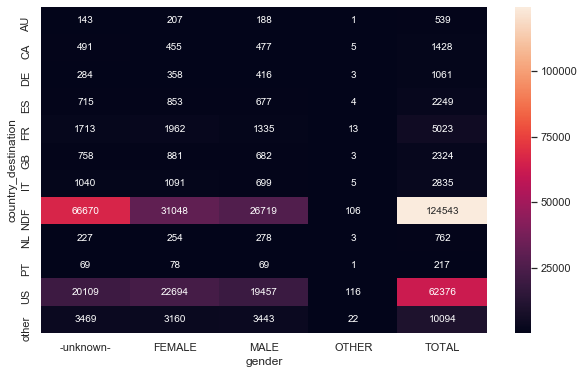

In [12]:
# Findings: 
# 1. A major chunk of populaiton in 'unknown' category
# 2. A major chunk of populaiton with country 'NDF' followed by 'US'
# 3. Each country has the same distribtution of populaiton in MALE/FEMALE categories
pd.options.display.max_columns = None
pivot_gender = df_train_2.pivot_table('id', index=['country_destination'], columns=['gender'],aggfunc='count').fillna(0).astype(int)
pivot_gender.columns
pivot_gender['TOTAL'] = pivot_gender['-unknown-'] + pivot_gender['FEMALE'] + pivot_gender['MALE'] + pivot_gender['OTHER']
# pivot_gender['% unknown'] = pivot_gender['-unknown-']/pivot_gender['TOTAL']
# pivot_gender['% FEMALE'] = pivot_gender['FEMALE']/pivot_gender['TOTAL']
# pivot_gender['% MALE'] = pivot_gender['MALE']/pivot_gender['TOTAL']
# pivot_gender['% OTHER'] = pivot_gender['OTHER']/pivot_gender['TOTAL']
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(pivot_gender,annot=True, fmt="d")

In [13]:
# Findings:
df_country_age = df_train_2.pivot_table('id', index=['country_destination'], columns=['age_bucket'],aggfunc='count').fillna(0).astype(int)
# fig, ax = plt.subplots(figsize=(15,6))
# sns.heatmap(df_country_age,annot=True, fmt="d",ax=ax)
df_country_age

age_bucket,0-4,5-9,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+,unknown
country_destination,,,,,,,,,,,,,,,,,,,,,
AU,0,0,7,18,88,99,82,42,28,26,18,9,6,5,0,0,0,0,0,6,105
CA,0,0,32,41,204,263,177,115,67,66,35,27,18,9,0,0,1,0,0,16,357
DE,0,1,18,64,179,192,118,89,49,37,33,24,22,7,1,0,0,1,0,9,217
ES,1,0,30,208,361,405,264,120,89,73,41,42,23,12,5,0,2,0,1,20,552
FR,0,2,74,290,650,853,572,360,246,228,145,98,83,36,8,7,0,0,1,39,1331
GB,0,1,31,142,318,360,283,144,130,99,90,64,42,16,12,1,4,0,1,25,561
IT,1,1,41,197,369,460,303,172,119,114,76,55,43,20,8,5,3,2,0,32,814
NDF,7,36,924,4426,11921,11719,8340,5585,4309,3063,2190,1505,919,450,187,94,69,52,92,473,68182
NL,0,0,11,66,125,131,94,53,30,21,18,20,10,7,3,0,1,0,0,7,165


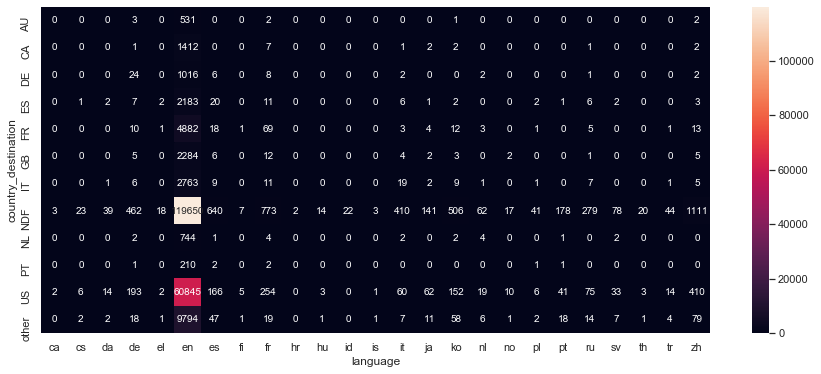

In [14]:
# Findings:
# 1. Almost the entire population speaks english
df_country_lang = df_train_2.pivot_table('id', index=['country_destination'], columns=['language'],aggfunc='count').fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(df_country_lang,annot=True, fmt="d",ax=ax)

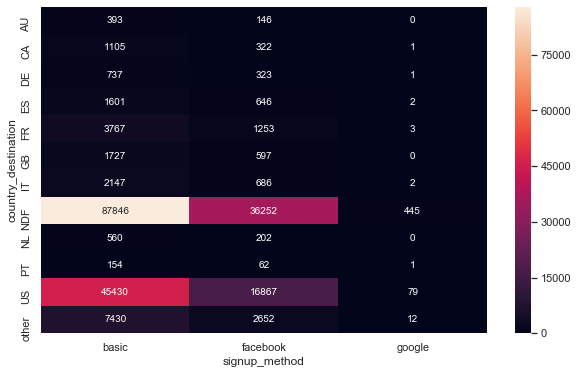

In [15]:
# Findings: Most of the signup happens through their own website and facebook
df_country_signup = df_train_2.pivot_table('id', index=['country_destination'], columns=['signup_method'],aggfunc='count').fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_country_signup,annot=True, fmt="d",ax=ax)

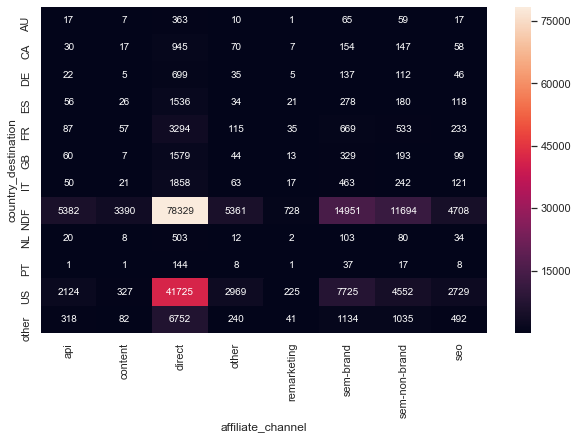

In [16]:
# Affiliate channel means the type of paid marketing channel used
df_country_aff_ch = df_train_2.pivot_table('id', index=['country_destination'], columns=['affiliate_channel'],aggfunc='count').fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_country_aff_ch,annot=True, fmt="d")

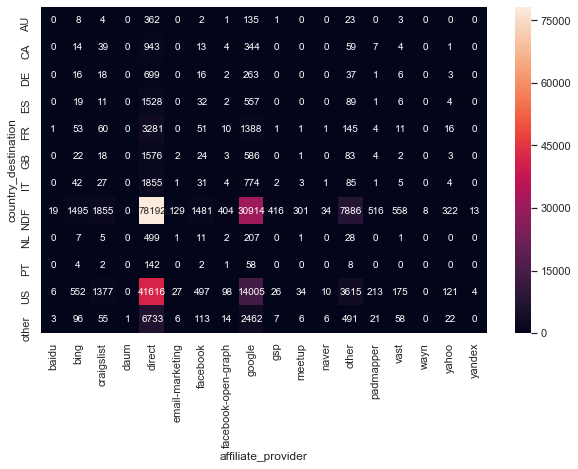

In [17]:
# Affiliate provider means the place for marketing e.g. google, craigslist, other
df_country_aff_prov = df_train_2.pivot_table('id', index=['country_destination'], columns=['affiliate_provider'],aggfunc='count').fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_country_aff_prov,annot=True, fmt="d",ax=ax)

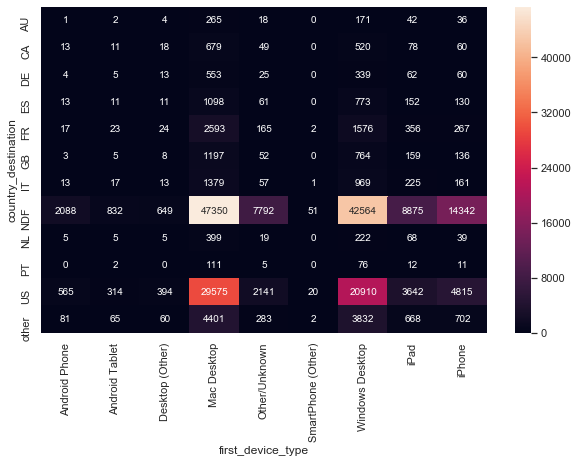

In [18]:
# Findings:
# 1. Since most of the population is concentrated in the US, so most users are either Mac Desktop users or Windows Desktop users 
df_country_dev_type = df_train_2.pivot_table('id', index=['country_destination'], columns=['first_device_type'],aggfunc='count').fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_country_dev_type,annot=True, fmt="d",ax=ax)

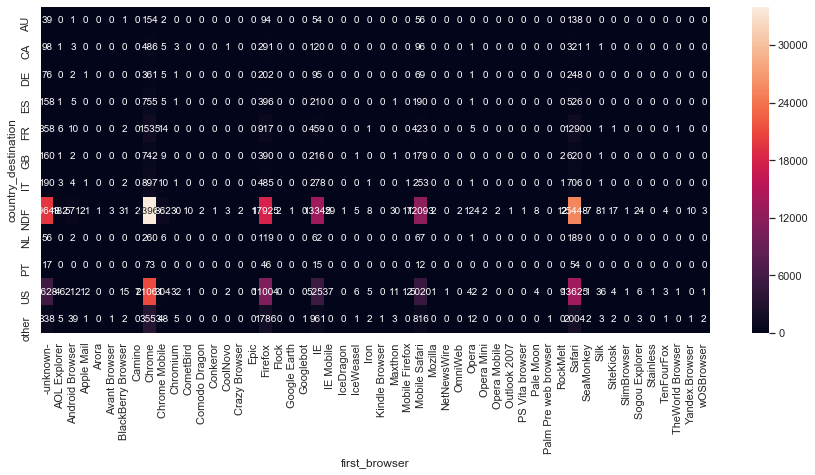

In [19]:
# QUESTION: This variable has too many distinct values, how do we decide weather we should use it in modeling?
df_country_browser = df_train_2.pivot_table('id', index=['country_destination'], columns=['first_browser'],aggfunc='count').fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(df_country_browser,annot=True, fmt="d",ax=ax)

In [20]:
# # df_train_3.columns
# check = df_train_3.pivot_table('id', index=['country_destination', 'age_bucket', 'gender'], aggfunc='count').fillna(0).astype(int)
# check_1 =  check.reset_index()
# check_1[check_1.country_destination=="US"]

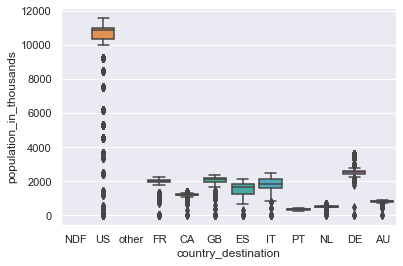

In [21]:
# This population could be the number of male/female in different age buckets who travelled to these destination countries in 2015 
ax = sns.boxplot(x='country_destination', y='population_in_thousands', data=df_train_3)

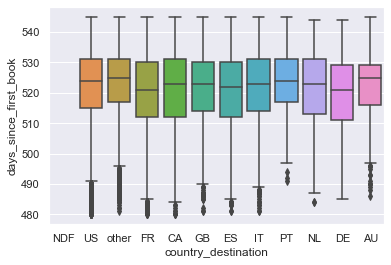

In [22]:
# Interpretation:
# The median days since first booking are more or less same for different countries with similar variability as well
ax = sns.boxplot(x='country_destination', y='days_since_first_book', data=df_train_3)

In [23]:
# plot # users vs time
# plot # users in diff age brackets
# plot # users with same language vs different
df_train.id.nunique()

213451

In [24]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [25]:
df_sessions.user_id.nunique()

135483

# Aggregate sessions dataset at user_id level to merge with train dataset later

In [26]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [27]:
df_sessions_agg = df_sessions.groupby('user_id').agg({'action': 'count', 'action_type':'nunique','device_type':'nunique','secs_elapsed':np.mean})
df_sessions_agg_1 = df_sessions_agg.reset_index()
df_sessions_agg_1.user_id = df_sessions_agg_1.user_id.str.strip()
df_sessions_agg_1.columns = ['user_id','cnt_action','cnt_uniq_action_type','cnt_uniq_dev_type','secs_per_session']
df_sessions_agg_1.head()

,user_id,cnt_action,cnt_uniq_action_type,cnt_uniq_dev_type,secs_per_session
0,00023iyk9l,39,6,2,22253.743590
1,0010k6l0om,63,5,1,9460.370968
2,001wyh0pz8,90,5,1,3179.382022
3,0028jgx1x1,31,5,2,9900.333333
4,002qnbzfs5,782,7,2,8232.335025


In [28]:
print(df_sessions.user_id.nunique())
print(df_sessions_agg_1.shape)

135483
(135483, 5)


In [29]:
df_train_3.id = df_train_3.id.str.strip()
df_train_4 = df_train_3.merge(df_sessions_agg_1, how = 'left', left_on=['id'],right_on = ['user_id'])
df_train_4[df_train_4.user_id.notnull()].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_language,distance_km,ind_same_lang,days_since_first_book,age_bucket,population_in_thousands,year,user_id,cnt_action,cnt_uniq_action_type,cnt_uniq_dev_type,secs_per_session
137021,d1mm9tcy42,2014-01-01,1970-01-01 05:35:40.101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,NaN,NaN,0,528.0,60-64,NaN,NaN,d1mm9tcy42,126.0,6.0,2.0,27202.611111
137022,yo8nz8bqcq,2014-01-01,1970-01-01 05:35:40.101001558,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,NaN,NaN,0,NaN,unknown,NaN,NaN,yo8nz8bqcq,9.0,4.0,1.0,25980.250000
137023,4grx6yxeby,2014-01-01,1970-01-01 05:35:40.101001639,NaT,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,NaN,NaN,0,NaN,unknown,NaN,NaN,4grx6yxeby,15.0,6.0,2.0,75696.266667
137024,ncf87guaf0,2014-01-01,1970-01-01 05:35:40.101002146,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,NaN,NaN,0,NaN,unknown,NaN,NaN,ncf87guaf0,152.0,5.0,3.0,24868.211921
137025,4rvqpxoh3h,2014-01-01,1970-01-01 05:35:40.101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,eng,6883.659,1,528.0,unknown,NaN,NaN,4rvqpxoh3h,8.0,1.0,1.0,365.000000


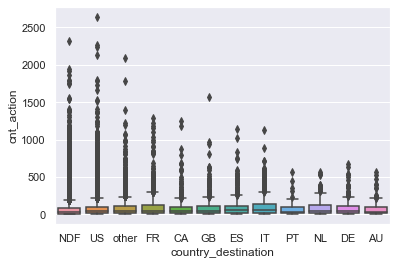

In [30]:
ax = sns.boxplot(x='country_destination', y='cnt_action', data=df_train_4)

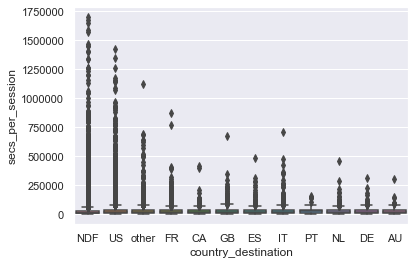

In [31]:
# US has the higher secs per session across all countries
ax = sns.boxplot(x='country_destination', y='secs_per_session', data=df_train_4)

# Perform Chi-Square test between target variable and independent variables to measure the association

1. The H0 (Null Hypothesis): There is no relationship between variable one and variable two.
2. The H1 (Alternative Hypothesis): There is a relationship between variable 1 and variable 2.

- If the p-value is significant, you can reject the null hypothesis and claim that the findings support the alternative hypothesis.

[Chi square test](https://pythonfordatascience.org/chi-square-test-of-independence-python/)

# Assumptions for Chi-square test
The following assumptions need to be meet in order for the results of the Chi-square test to be trusted.
- When testing the data, the cells should be counts of cases and not percentages. It is okay to convert to percentages after testing the data
- The levels (groups) of the variables being tested are mutually exclusive
- Each participant contributes to only one cell within the Chi-square table
- The groups being tested must be independent
- The value of expected cells should be greater than 5 for at least 20% of the cells

In [32]:
crosstab_gender = pd.crosstab(df_train_2['country_destination'], df_train_2['gender'])

In [33]:
from scipy import stats
chi_square, p_val, dof, expected_freq = stats.chi2_contingency(crosstab_gender)
print("% of expected frequencies with value>5", np.sum(expected_freq>5)/(expected_freq.shape[0]*expected_freq.shape[1]))
if p_val<0.05:
    print('P-value<alpha (5%): reject H0') 
    print("There's an association between the two variables")
else:
    print('P-value>alpha (5%): do not reject H0')
    print("There's no association between the two variables")

% of expected frequencies with value>5 0.8333333333333334
P-value<alpha (5%): reject H0
There's an association between the two variables


In [34]:
from scipy import stats
chi_square, p_val, dof, expected_freq = stats.chi2_contingency(pd.crosstab(df_train_2['country_destination'], df_train_2['language']))
print("% of expected frequencies with value>5", np.sum(expected_freq>5)/(expected_freq.shape[0]*expected_freq.shape[1]))
if p_val<0.05:
    print('P-value<alpha (5%): reject H0') 
    print("There's an association between the two variables")
else:
    print('P-value>alpha (5%): do not reject H0')
    print("There's no association between the two variables")

% of expected frequencies with value>5 0.3233333333333333
P-value<alpha (5%): reject H0
There's an association between the two variables


In [35]:
from scipy import stats
chi_square, p_val, dof, expected_freq = stats.chi2_contingency(pd.crosstab(df_train_2['country_destination'], df_train_2['signup_method']))
print("% of expected frequencies with value>5", np.sum(expected_freq>5)/(expected_freq.shape[0]*expected_freq.shape[1]))
if p_val<0.05:
    print('P-value<alpha (5%): reject H0') 
    print("There's an association between the two variables")
else:
    print('P-value>alpha (5%): do not reject H0')
    print("There's no association between the two variables")

% of expected frequencies with value>5 0.8611111111111112
P-value<alpha (5%): reject H0
There's an association between the two variables


In [36]:
from scipy import stats
chi_square, p_val, dof, expected_freq = stats.chi2_contingency(pd.crosstab(df_train_2['country_destination'], df_train_2['first_device_type']))
print("% of expected frequencies with value>5", np.sum(expected_freq>5)/(expected_freq.shape[0]*expected_freq.shape[1]))
if p_val<0.05:
    print('P-value<alpha (5%): reject H0') 
    print("There's an association between the two variables")
else:
    print('P-value>alpha (5%): do not reject H0')
    print("There's no association between the two variables")

% of expected frequencies with value>5 0.8425925925925926
P-value<alpha (5%): reject H0
There's an association between the two variables


In [37]:
from scipy import stats
chi_square, p_val, dof, expected_freq = stats.chi2_contingency(pd.crosstab(df_train_2['country_destination'], df_train_2['first_browser']))
print("% of expected frequencies with value>5", np.sum(expected_freq>5)/(expected_freq.shape[0]*expected_freq.shape[1]))
if p_val<0.05:
    print('P-value<alpha (5%): reject H0') 
    print("There's an association between the two variables")
else:
    print('P-value>alpha (5%): do not reject H0')
    print("There's no association between the two variables")

% of expected frequencies with value>5 0.1987179487179487
P-value<alpha (5%): reject H0
There's an association between the two variables


# Perform ANOVA between target variable and independent variables (continuous) to measure the association

# Assumptions for ANOVA

There are 3 assumptions that need to be met for the results of an ANOVA test to be considered accurate and trust worthy. It’s important to note the the assumptions apply to the residuals and not the variables themselves. The ANOVA assumptions are the same as for linear regression and are:

1. Normality
    - Caveat to this is, if group sizes are equal, the F-statistic is robust to violations of normality
2. Homogeneity of variance
    - Same caveat as above, if group sizes are equal, the F-statistic is robust to this violation
3. Independent observations

1. Measure association between country of destination and days since first booking using ANOVA

C:\Users\anuka\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\anuka\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


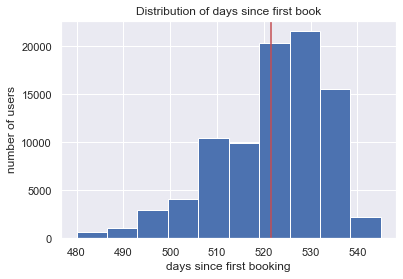

In [38]:
# Check the normality of days_since_first_book
_ = plt.hist(df_train_3['days_since_first_book'], bins=10)
_ = plt.xlabel('days since first booking')
_ = plt.ylabel('number of users')
_ = plt.title('Distribution of days since first book')
_ = plt.axvline(df_train_3['days_since_first_book'].mean(), color='r')
plt.show()

In [39]:
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import researchpy as rp

rp.summary_cont(df_train_3['days_since_first_book'].groupby(df_train_3['country_destination']))

C:\Users\anuka\Anaconda3\lib\site-packages\researchpy\summary.py:137: RuntimeWarning: invalid value encountered in sqrt
  l_ci = mean - (1.960 * (std/numpy.sqrt(cnt-1)))
C:\Users\anuka\Anaconda3\lib\site-packages\researchpy\summary.py:138: RuntimeWarning: invalid value encountered in sqrt
  u_ci = mean + (1.960 * (std/numpy.sqrt(cnt-1)))


,N,Mean,SD,SE,95% Conf.,Interval
country_destination,,,,,,
AU,539,521.929499,10.620115,0.457441,521.032082,522.826916
CA,1428,520.766106,12.380045,0.327611,520.123764,521.408448
DE,1061,519.147974,11.231600,0.344813,518.471821,519.824126
ES,2249,520.332148,11.723135,0.247200,519.847527,520.816768
FR,5023,519.683058,12.020421,0.169605,519.350599,520.015516
GB,2324,521.056799,11.196029,0.232245,520.601501,521.512096
IT,2835,521.462434,11.152006,0.209448,521.051843,521.873025
NDF,0,NaN,NaN,NaN,NaN,NaN
NL,762,521.173228,11.583504,0.419626,520.350221,521.996236


In [40]:
# Ignored users where country_destinaiton = "NDF", where user didn't make a booking
# The F-statistic= 38.99853794606649 and the p-value= 1.9154523178321722e-77 which is indicating that there is an 
# overall significant effect of days_since_first_book on country of destination but this test may not be very reliable 
# because it may violate some of the assumptions of ANOVA
stats.f_oneway(df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'US'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'other'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'FR'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'IT'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'GB'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'ES'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'CA'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'DE'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'NL'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'AU'],
               df_train_3['days_since_first_book'][df_train_3['country_destination'] == 'PT'])

F_onewayResult(statistic=38.99853794606649, pvalue=1.9154523178321722e-77)

2. Measure association between country of destination and population using ANOVA

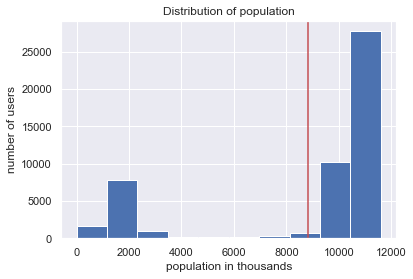

In [49]:
# Check the normality of population in thousands
_ = plt.hist(df_train_3['population_in_thousands'][(df_train_3['country_destination'] != "other") 
                                                   & (df_train_3['country_destination'] != "NDF")], bins=10)
_ = plt.xlabel('population in thousands')
_ = plt.ylabel('number of users')
_ = plt.title('Distribution of population')
_ = plt.axvline(df_train_3['population_in_thousands'][(df_train_3['country_destination'] != "other") 
                                                   & (df_train_3['country_destination'] != "NDF")].mean(), color='r')
plt.show()

In [41]:
rp.summary_cont(df_train_3['population_in_thousands'].groupby(df_train_3['country_destination']))

,N,Mean,SD,SE,95% Conf.,Interval
country_destination,,,,,,
AU,369,810.850949,102.132517,5.316806,800.415859,821.286038
CA,871,1212.051665,125.404342,4.249164,1203.718518,1220.384811
DE,719,2590.936022,408.640618,15.239723,2561.045371,2620.826674
ES,1424,1570.646067,358.819129,9.508688,1552.002492,1589.289643
FR,3051,2012.126844,231.011106,4.182267,2003.928257,2020.325431
GB,1468,2045.726839,296.813212,7.746762,2030.538012,2060.915667
IT,1657,1887.207604,366.892513,9.013171,1869.536456,1904.878752
NDF,0,NaN,NaN,NaN,NaN,NaN
NL,494,516.753036,75.603346,3.401555,510.079230,523.426843


In [45]:
# DOUBT - Not sure why getting f statistic = nan
# Ignored users where country_destinaiton = "NDF" and "other" as these groups have missing population values
# The F-statistic= '' and the p-value= '' which is indicating that there is an 
# overall significant effect of population_in_thousands on country of destination but this test may not be very reliable 
# because it may violate some of the assumptions of ANOVA
stats.f_oneway(df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'US'],
               df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'FR'],
               df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'IT'],
               df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'GB'],
               df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'ES'],
               df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'CA'],
               df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'DE'],
               df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'NL'],
               df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'AU'],
               df_train_3['population_in_thousands'][df_train_3['country_destination'] == 'PT'])

F_onewayResult(statistic=nan, pvalue=nan)

3. Measure association between country of destination and secs per sessio using ANOVA

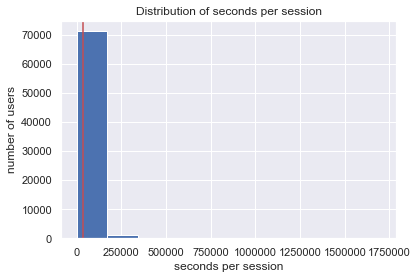

In [55]:
# Check the normality of population in thousands
_ = plt.hist(df_train_4['secs_per_session'], bins=10)
_ = plt.xlabel('seconds per session')
_ = plt.ylabel('number of users')
_ = plt.title('Distribution of seconds per session')
_ = plt.axvline(df_train_4['secs_per_session'].mean(), color='r')
plt.show()

In [53]:
rp.summary_cont(df_train_4['secs_per_session'].groupby(df_train_4['country_destination']))

,N,Mean,SD,SE,95% Conf.,Interval
country_destination,,,,,,
AU,150,30943.209484,34913.145939,2850.646429,25337.224618,36549.194349
CA,431,29927.784118,38219.661211,1840.976302,26315.277290,33540.290945
DE,249,31708.658081,34863.326125,2209.373522,27369.564173,36047.751990
ES,702,31599.544435,38436.314373,1450.685201,28754.174101,34444.914769
FR,1419,32938.589303,50238.698382,1333.666312,30323.681779,35553.496828
GB,727,36236.834532,46502.249571,1724.672971,32854.148239,39619.520825
IT,974,34022.652236,46704.218675,1496.499695,31088.005955,36957.298517
NDF,44222,30488.885282,61479.017330,292.353116,29915.866695,31061.903868
NL,246,33498.567210,45227.470801,2883.598217,27835.192057,39161.942363


In [54]:
stats.f_oneway(df_train_4['secs_per_session'][df_train_4['country_destination'] == 'NDF'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'other'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'US'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'FR'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'IT'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'GB'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'ES'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'CA'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'DE'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'NL'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'AU'],
               df_train_4['secs_per_session'][df_train_4['country_destination'] == 'PT'])

F_onewayResult(statistic=nan, pvalue=nan)

In [ ]:
# Machine learning algorithms to use:
# xgboost, multinomial logical regression and random forests